this notebook will be used to show the performance of the first attempt at learning reward.

first load the trained reward network anbd setup methods.

In [1]:
from baselines.common.vec_env import VecFrameStack
from LearningModel.AgentClasses import *
from baselines.common.cmd_util import make_vec_env
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
import re

/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/patrick/PycharmP

In [2]:


#setup the env
model_path = "/home/patrick/models/HalfCheetah-v2-demonstator"
env_id = 'HalfCheetah-v2'
env_type = 'mujoco'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
#env = VecFrameStack(env, 4)

#load the reward network
trainedNetwork = RewardNetwork("", env_type, env=env)

trainedNetwork.load_state_dict(torch.load("/home/patrick/models/halfcheetah-reward/fullTest.params"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPO2Agent(env, env_type, True)
trainedNetwork.to(device)

#run the agent in the env once and save the ground truth reward and observations
def GetDemoFromAgent(agent, network, env):
    trueReward = 0
    learnedReward = 0

    currentReward = 0
    currentObservation = env.reset()
    timeSteps = 0
    done = False

    #run the demo
    while True:
        trueReward += currentReward
        shapedObservation = torch.from_numpy(currentObservation).float().to(device)
        reward, abs_reward = network.predict_reward(shapedObservation)
        learnedReward += reward.tolist()

        action = agent.act(currentObservation,  currentReward, done)
        currentObservation, currentReward, done, info = env.step(action)
        shapedObservations = currentObservation
        timeSteps += 1

        if done:
            trueReward += currentReward
            reward, abs_reward = network.predict_reward(shapedObservation)
            learnedReward += reward.tolist()
            break
    print("{}, {}".format(trueReward, learnedReward))
    return trueReward, learnedReward

#a method to find all the models in a given dir that are just numbers
def Find_all_Models(model_dir):

    checkpoints = []
    filesandDirs = listdir(model_dir)
    allFiles = []
    for i in filesandDirs:
        if isfile(join(model_dir, i)):
            allFiles.append(i)

    for file in allFiles:
        if re.match('^[0-9]+$',file.title()):
            checkpoints.append(file.title())

    return checkpoints




Logging to /tmp/openai-2020-03-10-19-30-32-921527





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


now load all models and run each to get demos to run the network on

In [3]:
trueRewards = []
learnedRewards = []

models = Find_all_Models(model_path)

for i in range(10):
    for model in models:
        agent.load(model_path + "/" + model)
        trueReward, learnedReward = GetDemoFromAgent(agent, trainedNetwork, env)
        tf.keras.backend.clear_session()
        trueRewards.append(trueReward[0])
        learnedRewards.append(learnedReward)
    
maxTrue = max(trueRewards)
maxLearned = max(learnedRewards)
normalisedRewards = learnedRewards / (maxLearned / maxTrue)


[-277.4906], 65.05813762690195
[-18.953127], 62.465928643734514
[3.4790568], 74.68533822452628
[125.0518], 74.02141992382622
[-77.4743], 65.91518497290963
[202.62384], 80.85358747400142
[-455.02658], 63.92270459324527
[-89.4324], 63.57378277088719
[-187.45236], 62.95186668358201
[-186.34514], 67.84612775192181
[250.54468], 91.6237767055809
[-311.28494], 59.626155219394605
[-363.797], 61.22752389349489
[34.587387], 71.1147487910007
[20.582886], 78.06045955614502
[7.1722536], 83.3375358464873
[-178.27124], 64.50437322046128
[-216.39008], 65.74306311689452
[-148.0699], 63.38038221886154
[191.41428], 86.23614380637446
[-76.16042], 63.61151640099172
[-262.13284], 64.60098559162475
[-187.84767], 60.10920625370068
[-6.480055], 71.7821288885907
[29.509464], 66.03388828112247
[120.334145], 77.27072806628303
[68.74084], 75.36150493948571
[-246.72856], 70.22537499246937
[-305.48157], 68.39321252010541
[-28.481869], 66.9682053005838
[-270.16147], 70.8051185134027
[-207.9636], 63.28063578532232
[74

In [7]:
minLearned = min(learnedRewards)
normalisedRewards = [x-minLearned for x in learnedRewards]
copyLearned = []
copyTrue = []
for i in range(len(normalisedRewards)):
    if normalisedRewards[i] > 50000:
        pass
    else:
        copyLearned.append(normalisedRewards[i])
        copyTrue.append(trueRewards[i])
        
minTrue = min(copyTrue)
copyTrue = [x-minTrue for x in copyTrue]
        
maxTrue = max(copyTrue)
maxLearned = max(copyLearned)
copyLearned = copyLearned / (maxLearned / maxTrue)

814.791015625,38.55814916246436


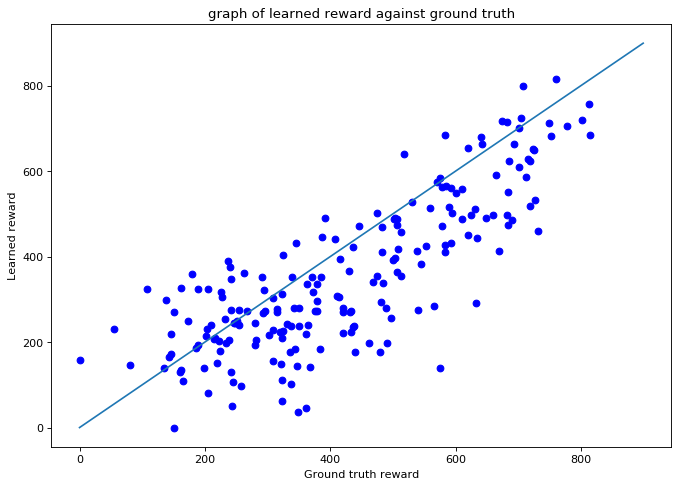

In [13]:
from matplotlib.pyplot import figure

print("{},{}".format(maxTrue, maxLearned))

figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.array(copyTrue), np.array(copyLearned), c='b')
plt.plot(np.arange(900), np.arange(900))
plt.ylabel("Learned reward")
plt.xlabel("Ground truth reward")
plt.title("graph of learned reward against ground truth")
plt.show()

In [10]:
minReward = [min(trueRewards)]
maxReward = [max(trueRewards)]
average = [sum(trueRewards) / len(trueRewards)]

from LearningModel.getAverageReward import *
agent.load("~/models/halfcheetah-reward-rl/halfcheetah_2M_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)

minReward.append(minR)
maxReward.append(maxR)
average.append(meanR)


mins: [-509.70914, -396.09625244140625], maxs: [305.0819, 278.97705078125], means: [-85.6378752040863, -101.46020640134812]


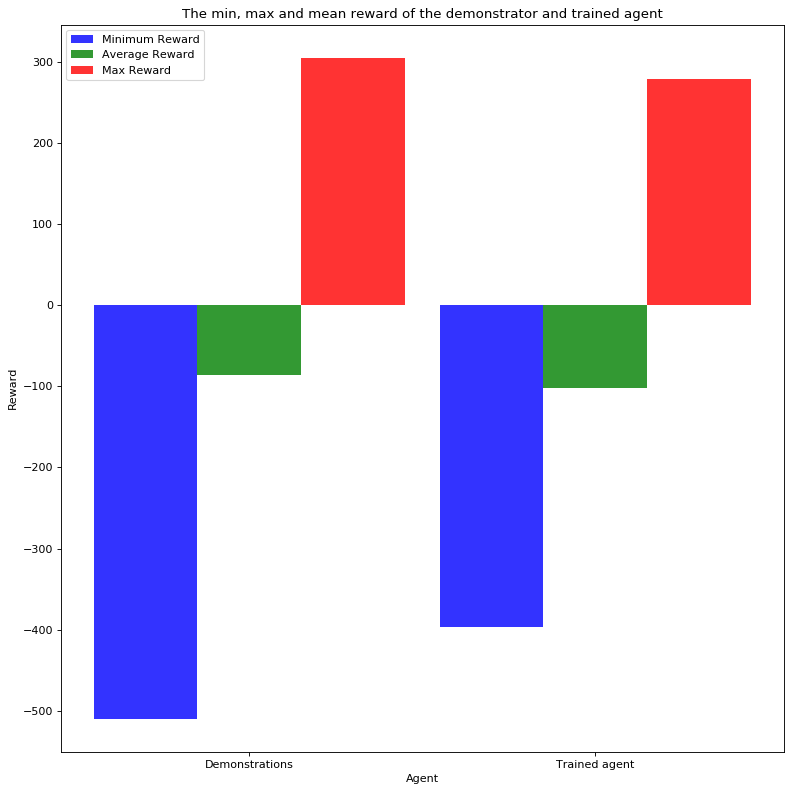

In [11]:

print("mins: {}, maxs: {}, means: {}".format(minReward, maxReward, average))
# create plot
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, minReward, bar_width,
alpha=opacity,
color='b',
label='Minimum Reward')

rects2 = plt.bar(index + bar_width, average, bar_width,
alpha=opacity,
color='g',
label='Average Reward')

rects3 = plt.bar(index + bar_width +bar_width, maxReward, bar_width,
alpha=opacity,
color='r',
label='Max Reward')

plt.xlabel('Agent')
plt.ylabel('Reward')
plt.title('The min, max and mean reward of the demonstrator and trained agent')
plt.xticks(index + bar_width, ('Demonstrations', 'Trained agent'))
plt.legend()

plt.tight_layout()
plt.show()

/home/patrick/PycharmProjects/comp300/baselines-master/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


(<Figure size 432x432 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60803ff60>]],
       dtype=object))

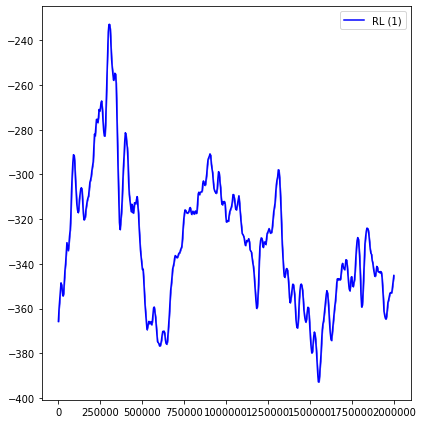

In [14]:
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/halfcheetah-reward-RL')
pu.plot_results(results, average_group=True, split_fn=lambda _: '')